In [1]:
%matplotlib inline

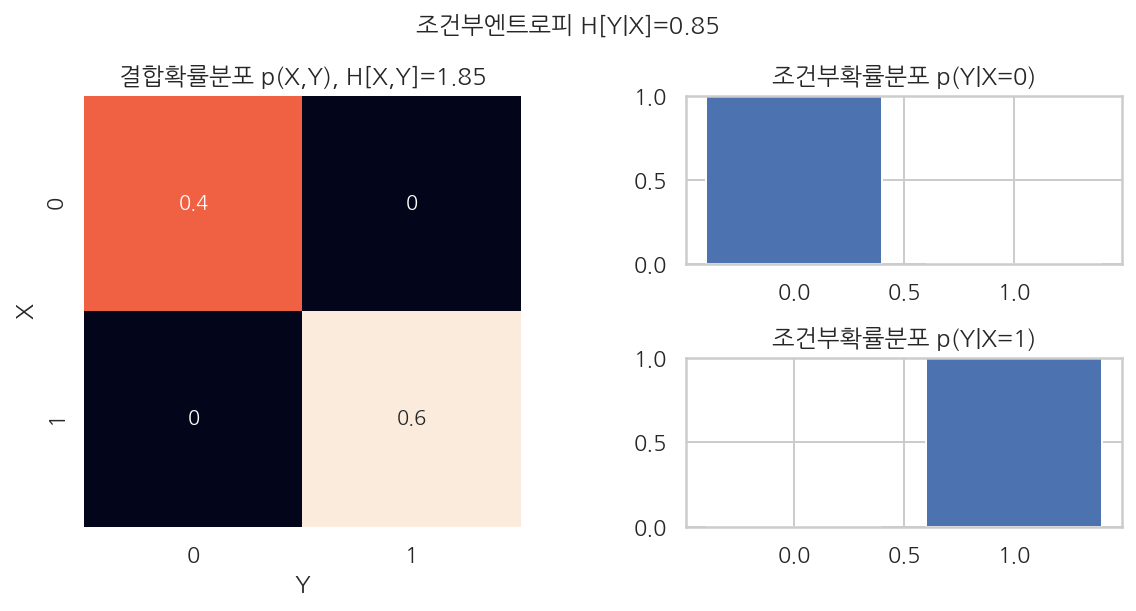

In [2]:
# 예측에 도움이 되는 경우
plt.figure(figsize = (8, 4), facecolor = "1.")
ax1 = plt.subplot(121)
pXY = [[0.4, 0], [0, 0.6]]
sns.heatmap(pXY, annot=True, cbar=False)
plt.xlabel("Y")
plt.ylabel("X")
plt.title("결합확률분포 p(X,Y), H[X,Y]=1.85")

plt.subplot(222)
plt.bar([0, 1], [1, 0])
plt.ylim(0, 1)
plt.title("조건부확률분포 p(Y|X=0)")

plt.subplot(224)
plt.bar([0, 1], [0, 1])
plt.ylim(0, 1)
plt.title("조건부확률분포 p(Y|X=1)")

plt.tight_layout(w_pad=5)
plt.suptitle("조건부엔트로피 H[Y|X]=0.85", y=1.05)
plt.show()

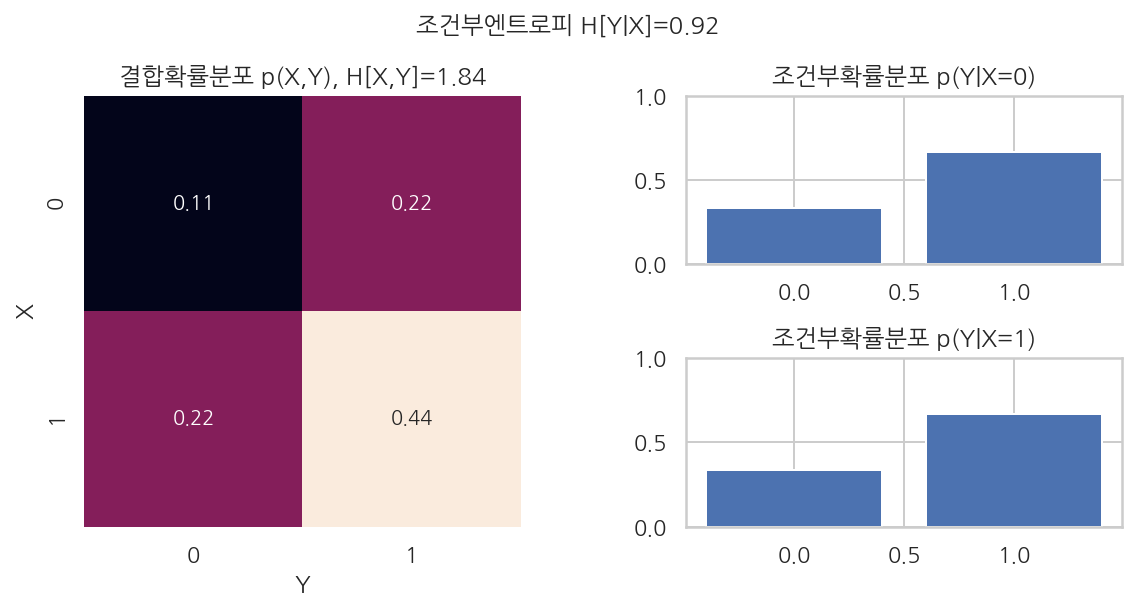

In [3]:
# 예측에 도움이 되지않는 경우
plt.figure(figsize=(8, 4), facecolor="1.")
ax1 = plt.subplot(121)
pXY = [[1/9, 2/9], [2/9, 4/9]]
sns.heatmap(pXY, annot=True, cbar=False)
plt.xlabel("Y")
plt.ylabel("X")
plt.title("결합확률분포 p(X,Y), H[X,Y]=1.84")

plt.subplot(222)
plt.bar([0, 1], [1/3, 2/3])
plt.ylim(0, 1)
plt.title("조건부확률분포 p(Y|X=0)")

plt.subplot(224)
plt.bar([0, 1], [1/3, 2/3])
plt.ylim(0, 1)
plt.title("조건부확률분포 p(Y|X=1)")

plt.tight_layout(w_pad=5)
plt.suptitle("조건부엔트로피 H[Y|X]=0.92", y=1.05)
plt.show()

In [4]:
from sklearn.datasets import load_iris

iris = load_iris()
idx = np.in1d(iris.target, [1, 2])
X = iris.data[idx, :]
y = iris.target[idx]
df = pd.DataFrame(X, columns=iris.feature_names)
df["species"] = iris.target[idx]
df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
95,6.7,3.0,5.2,2.3,2
96,6.3,2.5,5.0,1.9,2
97,6.5,3.0,5.2,2.0,2
98,6.2,3.4,5.4,2.3,2
99,5.9,3.0,5.1,1.8,2


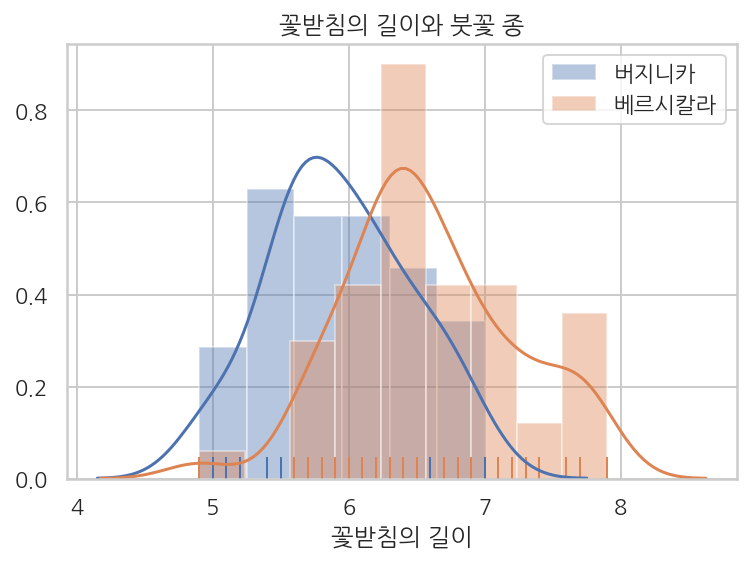

In [5]:
plt.figure(facecolor="1.")
sns.distplot(df[df.species == 1]["sepal length (cm)"], hist=True, rug=True, label="버지니카")
sns.distplot(df[df.species == 2]["sepal length (cm)"], hist=True, rug=True, label="베르시칼라")
plt.legend()
plt.xlabel("꽃받침의 길이")
plt.title("꽃받침의 길이와 붓꽃 종")
plt.show()

# 꽃받침의 길이가 크면 베르시칼라 길이가 작으면 버지니카 -> 대략적인 정보
# 분류문제에서 명시적이고 수치적인 기준 -> 기준값을 어디로 잡는가?

In [6]:
# 6센치를 기준으로 분류할 경우
df["X1"] = df["sepal length (cm)"] > 6
pivot_table1 = df.groupby(["X1", "species"]).size().unstack().fillna(0)
pivot_table1

species,1,2
X1,,
False,30,9
True,20,41


In [7]:
# 이 때의 조건부 엔트로피
# 조건부 엔트로피 계산을 위한 함수
def cond_entropy(v):
    pYX0 = v[0, :] / np.sum(v[0, :])
    pYX1 = v[1, :] / np.sum(v[1, :])
    HYX0 = sp.stats.entropy(pYX0, base=2)
    HYX1 = sp.stats.entropy(pYX1, base=2)
    HYX = np.sum(v, axis=1) @ [HYX0, HYX1] / np.sum(v)
    return HYX

cond_entropy(pivot_table1.values)

0.860714271586387

In [8]:
# 6.5센치를 기준으로 분류할 경우
df["X2"] = df["sepal length (cm)"] > 6.5
pivot_table2 = df.groupby(["X2", "species"]).size().unstack()
pivot_table2

species,1,2
X2,,
False,42,28
True,8,22


In [9]:
cond_entropy(pivot_table2.values)

0.9306576387006182

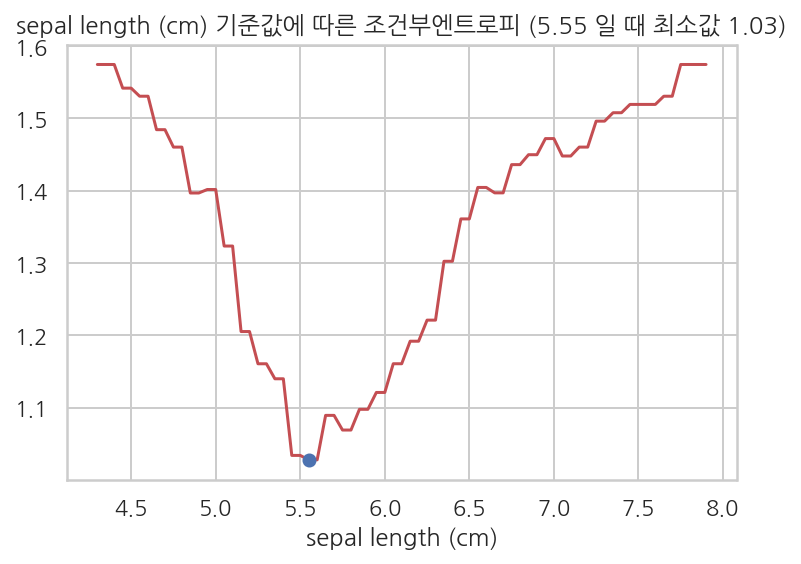

In [12]:
# 6센치와 6.5센치 두개의 기준중에서 선택해야할 경우
# 조건부 엔트로피의 값이 작은 값이 더 분류에 도움이 많이됨 -> 6센치가 더 좋은 기준값
# 조건부 엔트로피 값이 가장 작게 나오는 위치를 찾는 것
# 연습문제 10.2.1
iris = load_iris()
X = iris.data
y = iris.target
df = pd.DataFrame(X, columns=iris.feature_names)
df["species"] = iris.target

def calc_cond_entropies(col, threshold):
    df["X1"] = df[col] > threshold
    pivot_table1 = df.groupby(["X1", "species"]).size().unstack().fillna(0)
    v = pivot_table1.values
    pYX0 = v[0, :] / np.sum(v[0, :])
    pYX1 = v[1, :] / np.sum(v[1, :])
    HYX0 = sp.stats.entropy(pYX0, base=2)
    HYX1 = sp.stats.entropy(pYX1, base=2)
    HYX = np.sum(v, axis=1) @ [HYX0, HYX1] / np.sum(v)
    return HYX

def plot_min_cond_entropy(col):
    th_min = df[col].min()
    th_max = df[col].max()
    th_range = np.arange(th_min, th_max + 0.05, 0.05)
    cond_entropies = []
    for th in th_range:
        cond_entropies.append(calc_cond_entropies(col, th))
    
    id_min = np.argmin(cond_entropies)
    th_min = th_range[id_min]
    ce_min = np.min(cond_entropies)
    plt.figure(facecolor="1.")
    plt.plot(th_range, cond_entropies, "r-")
    plt.plot(th_min, ce_min, "bo")
    title = "{} 기준값에 따른 조건부엔트로피 ({:.3} 일 때 최소값 {:.3})".format(col, th_min, ce_min)
    plt.title(title)
    plt.xlabel(col)
    plt.show()
    
plot_min_cond_entropy("sepal length (cm)")

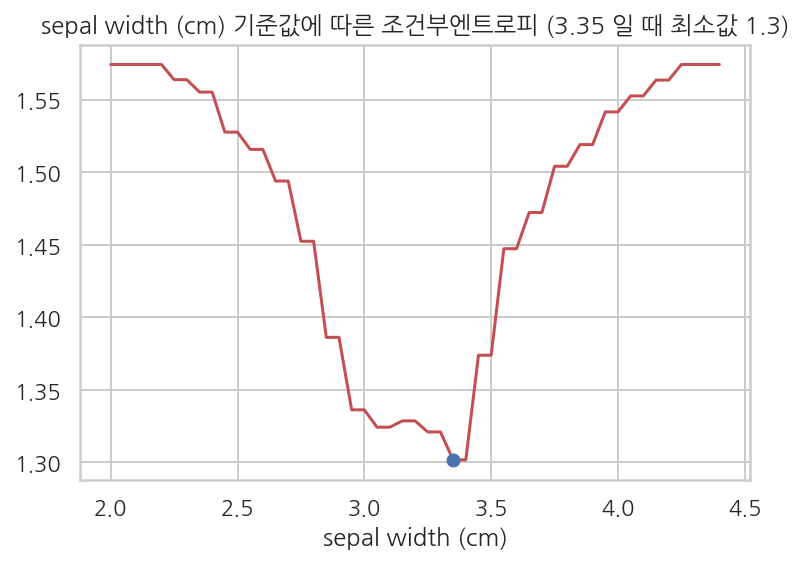

In [13]:
plot_min_cond_entropy("sepal width (cm)")